In [2]:
def perf_comp_data(func_list, data_list, rep=3, number=1):
    ''' Function to compare the performance of different functions.
    '''
    from timeit import repeat
    res_list = {}
    for name in enumerate(func_list):
        stmt = name[1] + '(' + data_list[name[0]] + ')'
        setup = "from __main__ import " + name[1] + ', ' \
                                    + data_list[name[0]]
        results = repeat(stmt=stmt, setup=setup,
                         repeat=rep, number=number)
        res_list[name[1]] = sum(results) / rep
    res_sort = sorted(res_list.items(),
                      key=lambda x: (x[1], x[0]))
    for item in res_sort:
        rel = item[1] / res_sort[0][1]
        print ('function: ' + item[0] +
              ', av. time sec: %9.5f, ' % item[1]
            + 'relative: %6.1f' % rel)

# 1.Python 泛型与性能

In [3]:
from math import *
def f(x):
    return abs(cos(x))**0.5 + sin(2 + 3*x)

In [4]:
# 显示循环标准的python函数
def f1(a):
    res = []
    for x in a:
        res.append(f(x))
    return res

In [5]:
# 隐式循环的迭代字方法
def f2(a):
    return [f(x) for x in a]

In [6]:
# 隐式循环，使用eval的迭代字方法
def f3(a):
    ex = 'abs(cos(x))**0.5 + sin(2 + 3*x)'
    return [eval(ex) for x in a]



In [7]:
# Numpy 向量化实现
def f4(a):
    return (np.abs(np.cos(a))**0.5 + np.sin(2 + 3*a))

In [8]:
import numexpr as ne
# 单线程
def f5(a):
    ex = 'abs(cos(a)) ** 0.5 + sin(2 + 3*a)'
    ne.set_num_threads(1)  # 1个线程
    return ne.evaluate(ex)

In [9]:
# 多线程
def f6(a):
    ex = 'abs(cos(a)) ** 0.5 + sin(2 + 3*a)'
    ne.set_num_threads(16)  # 16个线程
    return ne.evaluate(ex)


In [10]:
import numpy as np

In [11]:
I = 500000
a_py = range(I)
a_np = np.arange(I)

In [12]:
%%time
r1 = f1(a_py)
r2 = f2(a_py)
r3 = f3(a_py)
r4 = f4(a_np)
r5 = f5(a_np)
r6 = f6(a_np)

CPU times: user 9.64 s, sys: 119 ms, total: 9.76 s
Wall time: 9.78 s


In [13]:
np.allclose(r1,r2)

True

In [14]:
np.allclose(r1, r3)

True

In [15]:
np.allclose(r1,r4)

True

In [16]:
func_list = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
data_list = ['a_py', 'a_py', 'a_py', 'a_np', 'a_np', 'a_np']
perf_comp_data(func_list, data_list)

function: f6, av. time sec:   0.00545, relative:    1.0
function: f5, av. time sec:   0.02066, relative:    3.8
function: f4, av. time sec:   0.02257, relative:    4.1
function: f2, av. time sec:   0.31375, relative:   57.5
function: f1, av. time sec:   0.35042, relative:   64.2
function: f3, av. time sec:   8.94869, relative: 1640.7


# 2. 内存布局与性能

In [17]:
import numpy as np
# C表示类似行优先，F列优先
np.zeros((3,3), dtype=np.float64, order='C')

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [18]:
c = np.array([
    [1,1,1],
    [2,2,2],
    [3,3,3]], order='C')  # 行优先

f = np.array([
    [1,1,1],
    [2,2,2],
    [3,3,3]], order='F')  # 列优先

In [19]:
x = np.random.standard_normal((3, 1500000))
C = np.array(x, order= 'C')
F = np.array(x, order= 'F')
x = 0.0

In [20]:
%timeit C.sum(axis=0)

7.53 ms ± 660 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit F.sum(axis=1)

25.5 ms ± 877 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


# 并行计算

![izAkmF.png](https://s1.ax1x.com/2018/11/17/izAkmF.png)

In [22]:
def bsm_mcs_valuation(strike):
    import numpy as np
    S0=100
    T=1.0
    r= 0.5
    vola=0.2
    M = 50
    I=20000
    dt = T/M
    rand = np.random.standard_normal((M+1,I))
    S = np.zeros((M+1, I))
    S[0] = S0
    for t in range(1,M+1):
        S[t] = S[t-1]*np.exp((r-0.5*vola**2)*dt 
                            + vola*np.sqrt(dt)*rand[t])
    value = (np.exp(-r*T) * 
                np.sum(np.maximum(S[-1] - strike, 0)) / I)
    return value

In [23]:
# 顺序化计算
def seq_value(n):
    strikes = np.linspace(80, 120, n)
    option_values = []
    for strike in strikes:
        option_values.append(bsm_mcs_valuation(strike))
    return strikes, option_values

In [24]:
n=100
%time strikes, option_values_seq= seq_value(n)
print(strikes)

CPU times: user 4.79 s, sys: 225 ms, total: 5.02 s
Wall time: 5.02 s
[ 80.          80.4040404   80.80808081  81.21212121  81.61616162
  82.02020202  82.42424242  82.82828283  83.23232323  83.63636364
  84.04040404  84.44444444  84.84848485  85.25252525  85.65656566
  86.06060606  86.46464646  86.86868687  87.27272727  87.67676768
  88.08080808  88.48484848  88.88888889  89.29292929  89.6969697
  90.1010101   90.50505051  90.90909091  91.31313131  91.71717172
  92.12121212  92.52525253  92.92929293  93.33333333  93.73737374
  94.14141414  94.54545455  94.94949495  95.35353535  95.75757576
  96.16161616  96.56565657  96.96969697  97.37373737  97.77777778
  98.18181818  98.58585859  98.98989899  99.39393939  99.7979798
 100.2020202  100.60606061 101.01010101 101.41414141 101.81818182
 102.22222222 102.62626263 103.03030303 103.43434343 103.83838384
 104.24242424 104.64646465 105.05050505 105.45454545 105.85858586
 106.26262626 106.66666667 107.07070707 107.47474747 107.87878788
 108.2828

Text(0, 0.5, 'European call option values')

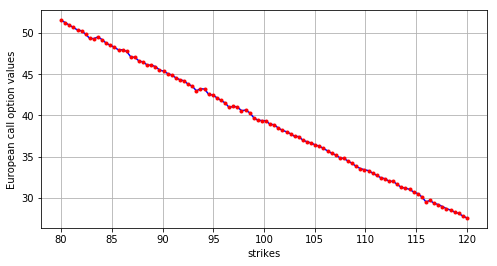

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(8,4))
plt.plot(strikes, option_values_seq, 'b')
plt.plot(strikes, option_values_seq, 'r.')
plt.grid(True)
plt.xlabel('strikes')
plt.ylabel('European call option values')

In [26]:
import multiprocessing as mp
import math
def simulate_geometric_brownian_motion(p):
    M,I = p # M步长，I样本数
    S0=100; r=0.05; sigma = 0.2; T=1.0;
    dt = T/M
    paths = np.zeros((M+1, I))
    paths[0] = S0
    for t in range(1, M +1):
        paths[t] = paths[t-1] * np.exp(
        (r - 0.5 * sigma **2) *dt + sigma * math.sqrt(dt) * np.random.standard_normal(I))
        
    return paths
        

In [27]:
paths = simulate_geometric_brownian_motion((5,2))
paths

array([[100.        , 100.        ],
       [109.31575302,  99.72784681],
       [129.34582866, 106.50522168],
       [109.98552958, 121.51757738],
       [117.23131372, 125.93111838],
       [104.48893281, 124.82681909]])

In [28]:
I = 10000
M = 100
t = 100
from time import  time
times = []
for w in range(1,17):
    t0 = time()
    pool = mp.Pool(processes=w)
    result = pool.map(simulate_geometric_brownian_motion, 
                      t*[(M,I),])
    times.append(time() - t0)

In [30]:
times

[14.82122802734375,
 10.821824073791504,
 8.241225957870483,
 6.985442876815796,
 6.074697017669678,
 6.692692041397095,
 5.8422980308532715,
 5.07908296585083,
 5.610527038574219,
 5.057176828384399,
 5.426337957382202,
 5.8693859577178955,
 4.849663019180298,
 4.17114520072937,
 4.727269172668457,
 5.115144968032837]

Text(0.5, 1.0, '100 Monte Carlo simulate')

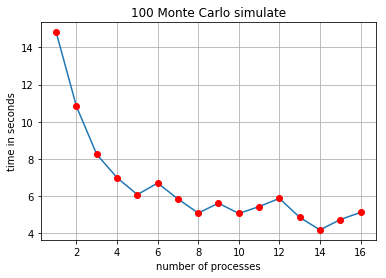

In [32]:
import matplotlib.pyplot as plt
plt.plot(range(1, 17), times)
plt.plot(range(1, 17), times, 'ro')
plt.grid(True)
plt.xlabel('number of processes')
plt.ylabel('time in seconds')
plt.title('%d Monte Carlo simulate' %t)

# 动态编译
`Numba`是开源的

In [33]:
from math import cos,log
def f_py(I,J):
    res = 0
    for i in range(I):
        for j in range(J):
            res += int(cos(log(1)))
    return res

In [34]:
I,J = 5000,5000
%time f_py(I,J)

CPU times: user 10.5 s, sys: 343 ms, total: 10.8 s
Wall time: 10.6 s


25000000

In [37]:
def f_np(I,J):
    a = np.ones((I,J), dtype=np.float64)
    return int(np.sum(np.cos(np.log(a)))),a

In [39]:
%time res,a=f_np(I,J)
res,a

CPU times: user 548 ms, sys: 279 ms, total: 827 ms
Wall time: 808 ms


(25000000, array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

In [40]:
import numba as nb
f_nb = nb.jit(f_py)
%time f_nb(I,J)

CPU times: user 196 ms, sys: 175 ms, total: 371 ms
Wall time: 501 ms


25000000

In [44]:
func_list = ['f_py', 'f_np', 'f_nb']
data_list = 3*['I,J']
print(data_list)
perf_comp_data(func_list, data_list)

['I,J', 'I,J', 'I,J']
function: f_nb, av. time sec:   0.00000, relative:    1.0
function: f_np, av. time sec:   0.71830, relative: 439596.8
function: f_py, av. time sec:  10.33231, relative: 6323319.1


# 二项式期权定价方式

In [45]:
S0=100
T=1
r=0.05
vola = 0.20

M=1000
dt = T/M
df = exp(-r*dt)

u=exp(vola * sqrt(dt))
d=1/u 
q=(exp(r*dt)-d)/(u-d)

import numpy as np
def binomial_py(strike):
    S = np.zeros((M+1, M+1)，dtype=np.float64)
    S[0,0] = S0
    z1=0
    for j in xrange(z1+1):
        S[i,j] = S[0,0]*(u**j)*(d**(i*2)
    

SyntaxError: invalid character in identifier (<ipython-input-45-b79bb50abe5a>, line 16)

# 用CPython进行静态编译

In [47]:
def f_py(I,J):
    res = 0
    for i in range(I):
        for j in range(I*J):
            res +=1
            
    return res

In [48]:
I,J=500,500
%time f_py(I,J)

CPU times: user 7.18 s, sys: 235 ms, total: 7.42 s
Wall time: 7.27 s


125000000